# HW2 for CS 135 in Fall 2023

[Main assignment instructions here](https://www.cs.tufts.edu/cs/135/2024f/Assignments/hw2.html)

This notebook is specifically for the report related to Problem 2

# Problem 2: Binary Classifier for Cancer-Risk Screening 

### Note: 
* You will need to finish **Code Task** for **Problem 1** before working on this notebook. 
* Your outputs, including tables and figures, don't need to be exactly the same as our sample outputs, but we do expect something as clear.

In [1]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

# %matplotlib inline
# plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# autoload changes in other files, so you don't have to restart the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2

# Import student-edited code 

Remember, you should have *completed* the Code Tasks for Problem 1 first. Note that this file needs to be in the same directory/folder as `binary_metrics.py` in order to function. 

In [3]:
if not os.path.exists('binary_metrics.py'):
    raise ImportError("CANNOT FIND binary_metrics.py. Make sure you run this notebook in same directory as your .py files.")

In [4]:
from binary_metrics import (
    calc_ACC, calc_TPR, calc_PPV)

# Import helper code (will work as provided, no edits needed)

In [5]:
import threshold_selection

In [6]:
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

# Provided function for computing mean binary cross entropy

Here, we provide a *completed* function you can use as-is for Problem 1.

Remember, we want the *base-2* cross entropy:

$$
BCE(y, p) = - y \log_2 p - (1-y) \log_2(1-p)
$$

In [7]:
def calc_mean_binary_cross_entropy_from_probas(ytrue_N, yproba1_N):
    ''' Compute mean binary cross entropy
    
    Args
    ----
    ytrue_N : 1D array, size (n_examples,) = (N,)
    yproba1_N : 1D array, size (n_examples,) = (N,)
    
    Returns
    -------
    mean_bce : float
        mean binary cross entropy across all N examples
    '''
    
    return sklearn.metrics.log_loss(ytrue_N, yproba1_N, labels=[0,1]) / np.log(2.0)

In [8]:
# Check that BCE loss is high if true class is 1 but probability is low
calc_mean_binary_cross_entropy_from_probas([1.], [0.01])

6.643856189774724

In [9]:
# Check that BCE loss is exactly 1 if true class is 1 but probability is 0.5
calc_mean_binary_cross_entropy_from_probas([1.], [0.5])

1.0

In [10]:
# Check that BCE loss is close to zero if true class is 1 but probability is 0.99
calc_mean_binary_cross_entropy_from_probas([1.], [0.99])

0.01449956969511509

# Load cancer dataset

In [11]:
# Make sure you have downloaded data and your directory is correct
DATA_DIR = os.path.join('data_cancer') 

In [12]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_valid.csv'), delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

for label, x in [('train', x_tr_M3), ('valid', x_va_N3), ('test', x_te_N3)]:
    print("Loaded %6s : shape %s" % (label, x.shape))

Loaded  train : shape (390, 3)
Loaded  valid : shape (180, 3)
Loaded   test : shape (180, 3)


In [13]:
N_shape = x_va_N3.shape
M_shape = x_tr_M3.shape

N = N_shape[0]
M = M_shape[0]

## Implementation Step 1A: Data Exploration

**TODO** : Load outcomes **y** arrays

In [14]:
# Load outcomes y arrays
y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)
y_va_N = np.loadtxt(os.path.join(DATA_DIR, 'y_valid.csv'), delimiter=',', skiprows=1)
y_te_N = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), delimiter=',', skiprows=1)

for label, y in [('train', y_tr_M), ('valid', y_va_N), ('test', y_te_N)]:
    print("Loaded %6s : shape %s" % (label, y.shape))

Loaded  train : shape (390,)
Loaded  valid : shape (180,)
Loaded   test : shape (180,)


In [15]:
# Load 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

### Table 1 

Create and print a pandas table summarizing some basic properties of the provided training set, validation set, and test set:

* Row 1 'total count': how many total examples are in each set?
* Row 2 'positive label count': how many examples have a positive label (means cancer)?
* Row 3 'fraction positive' : what fraction (between 0 and 1) of the examples have cancer?

Your result should be 3 by 3 containing 'total count', 'positive label count' and 'fraction positive' of training, valid and test sets. An example of the output looks like this (note that the numbers in this table are examples, not the numbers that should be in your table):

|                               | train  |valid    |test|
|:-|-:|-:|-:|
|num. total examples            |567.000  |123.000  |123.000
|num. positive examples         |56.000   |23.000   |23.000
|fraction of positive examples  |0.123    |0.123    |0.123

All results should **keep 3 digits**. We set a pandas display option to ensure that below.

**TODO**: make a pandas dataframe with the correct data properties

In [16]:
T1_columns = ['train', 'validation', 'test']
table1_df = pd.DataFrame(
    {
        label: [y_arr.shape[0], sum(y_arr), sum(y_arr)/len(y_arr)] for y_arr,label in zip([y_tr_M, y_va_N, y_te_N], T1_columns)
    },
    index = ['num. total examples', 'num. positive examples', 'fraction of positive examples']
)
table1_df

,train,validation,test
num. total examples,390.000000,180.000000,180.000000
num. positive examples,55.000000,25.000000,25.000000
fraction of positive examples,0.141026,0.138889,0.138889


In [17]:
pd.set_option('display.precision', 3)
print(table1_df)

                                 train  validation     test
num. total examples            390.000     180.000  180.000
num. positive examples          55.000      25.000   25.000
fraction of positive examples    0.141       0.139    0.139


##  Implementation Step 1B: The predict-0-always baseline

**TODO**: predict zero for all test data points

In [18]:
baseline_yhat_te_N = np.zeros(y_te_N.shape[0])
print(baseline_yhat_te_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [19]:
print(y_te_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, baseline_yhat_te_N, 0.5))

Predicted    0  1
True             
0          155  0
1           25  0


**TODO** Use the printed information from the previous code cell to calculate the accuracy of baseline. 

Keep 3 digits in your PDF report for short Answer 1a.

In [21]:
baseline_acc = calc_ACC(y_te_N, baseline_yhat_te_N)
print("Baseline has accuracy: ", baseline_acc)

Baseline has accuracy:  0.8611111111106328


#### Short Answer 1a

What *accuracy* does the "predict-0-always" classifier get on the *test* set (report to 3 decimal places)?
(You should see a pretty high number). Why isn't this classifier "good enough" to use in our screening task?

**Answer**  
The "predict-0-always" classifier achieves an accuracy of 86.11% which on the surface is a decent accuracy. As per the assignment description, we want a classifier that is good at identifying low-risk patients. This classifier fails that directive since it identifies no patients. We should rather focus in minimizing false negatives, since the consequences of failing to identify cancer in a patient could be fatal

## Implementation Step 1C : Logistic Regression with F=2 dataset

**TODO**: Complete each line marked TODO fixme in the codeblock below

In [66]:
C_grid = np.logspace(-9, 6, 31)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

model_F2_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list = list()
va_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list = list()
va_err_list = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 2-feature dataset
    lr_F2 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C) # TODO fixme
    lr_F2.fit(x_tr_M2, y_tr_M) # TODO fixme -- I Removed the [::5] why are we training every 5th data point only?
    
    model_F2_list.append(lr_F2)
    
    yproba1_tr_M = lr_F2.predict_proba(x_tr_M2)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_F2.predict_proba(x_va_N2)[:,1] # The probability of predicting class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list.append(my_tr_err)
    va_err_list.append(my_va_err)
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce = calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M)
    my_va_bce = calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N)
    # Save bce for future selection on Models.
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 

<>:8: SyntaxWarning:

invalid escape sequence '\l'

<>:8: SyntaxWarning:

invalid escape sequence '\l'

C:\Users\cbrad\AppData\Local\Temp\ipykernel_32560\2720266115.py:8: SyntaxWarning:

invalid escape sequence '\l'



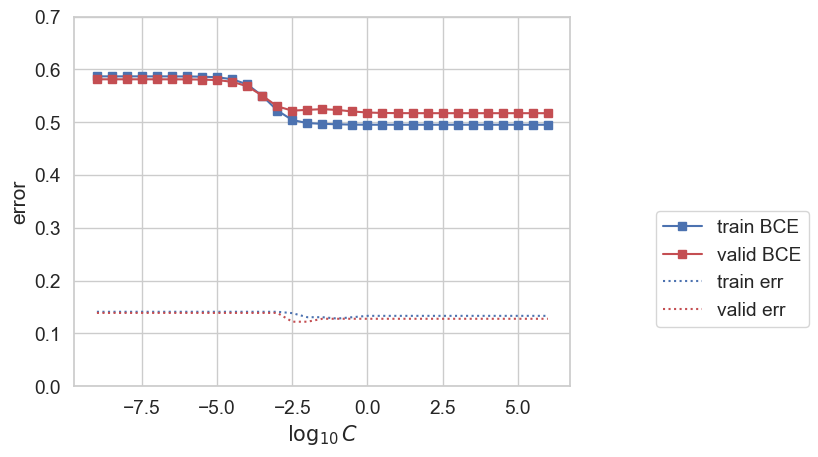

In [67]:
plt.plot(np.log10(C_grid), tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

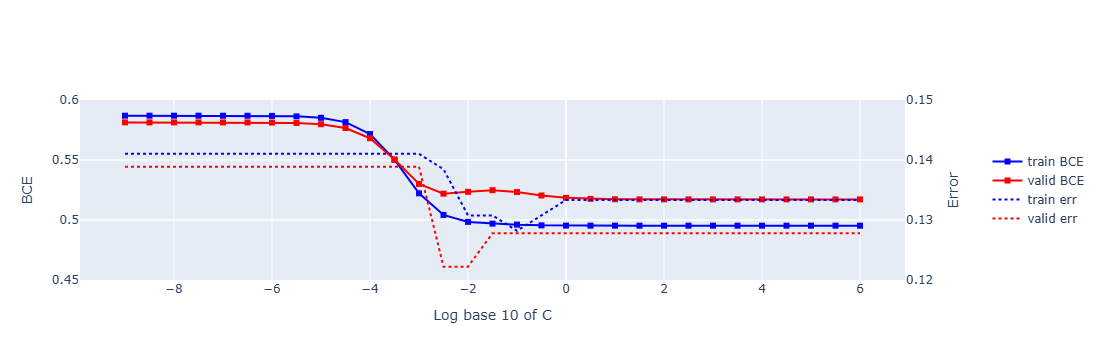

In [68]:
import plotly.graph_objects as go
# Create traces
fig = go.Figure()

# Left Y axis title "BCE"
fig.add_trace(go.Scatter(x=np.log10(C_grid), y=tr_bce_list, mode='lines+markers', name='train BCE', line=dict(color='blue'), marker=dict(symbol='square')))
fig.add_trace(go.Scatter(x=np.log10(C_grid), y=va_bce_list, mode='lines+markers', name='valid BCE', line=dict(color='red'), marker=dict(symbol='square')))

# Right Y axis title "Error"
fig.add_trace(go.Scatter(x=np.log10(C_grid), y=tr_err_list, mode='lines', name='train err', line=dict(color='blue', dash='dot'), yaxis='y2'))
fig.add_trace(go.Scatter(x=np.log10(C_grid), y=va_err_list, mode='lines', name='valid err', line=dict(color='red', dash='dot'), yaxis='y2'))

# Update layout
fig.update_layout(
    yaxis=dict(title='BCE', range=[0.45, 0.6]),
    yaxis2=dict(title='Error', overlaying='y', side='right', range=[0.12, 0.15]),
    xaxis_title='Log base 10 of C',
    hovermode='x',
    legend=dict(x=1.1, y=0.5)
)


fig.show()


### Check Point:

If your code is correct, you should produce exactly the same figure when you run the cell above as:

**"Checkpoint1C.jpg"** in the same folder as your starter code.
![image.png](Checkpoint1C.JPG)

**TODO** Find the best C with the samllest cross entropy loss on the validation set.

In [43]:
print(C_grid)
print(va_bce_list)

[1.00000000e-09 3.16227766e-09 1.00000000e-08 3.16227766e-08
 1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05 1.00000000e+06]
[0.5813487770068111, 0.5813487221108339, 0.581348549590922, 0.5813479998769558, 0.5813462647882099, 0.5813407781548239, 0.5813234345309908, 0.5812686357176725, 0.5810959164577515, 0.5805549146952722, 0.5788950721761505, 0.5741120458159739, 0.5625617108573815, 0.5440814099692152, 0.5291662857760788, 0.5232778061274768, 0.5204870803222317, 0.5162511063712238, 0.5108796608344197, 0.5073665001792881, 0.5059452994699977, 0.5054654572482143, 0.5053120170998245, 0.5052626145757986, 0.5052477216028025, 0.5052423844351842, 0.5052

In [63]:
# Find the best C with the smallest cross entropy loss on the validation set
best_C__lrF2 = C_grid[np.argmin(va_bce_list)]

print("Best C value for F2 model:")
print(best_C__lrF2)

Best C value for F2 model:
1000000.0


**TODO** Load the model that was rated 'best'

In [64]:
best_lrF2 = model_F2_list[np.argmin(va_bce_list)]

print("Best model has coefficient values:")
print(best_lrF2.coef_)

Best model has coefficient values:
[[0.23884306 0.43491051]]


In [65]:
# Output the prediction of your best model for 2-feature data on the training, valid, and test set. 
# Return the posibility of predicting true
# We'll use them for the ROC curve
bestlrF2_yproba1_tr_M = best_lrF2.predict_proba(x_tr_M2)[:,1]
bestlrF2_yproba1_va_N = best_lrF2.predict_proba(x_va_N2)[:,1]
bestlrF2_yproba1_te_N = best_lrF2.predict_proba(x_te_N2)[:,1]

## Implementation Step 1D : Logistic Regression with F=3 dataset
**TODO**: 
* Repeat Step 1C for 3-feature Dataset to find the best C. 

In [74]:
C_grid = np.logspace(-9, 6, 31)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

model_F3_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list_F3 = list()
va_bce_list_F3 = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list_F3 = list()
va_err_list_F3 = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 2-feature dataset
    lr_F3 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C) # TODO fixme
    lr_F3.fit(x_tr_M3, y_tr_M) # TODO fixme
    
    model_F3_list.append(lr_F3)
    
    yproba1_tr_M = lr_F3.predict_proba(x_tr_M3)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_F3.predict_proba(x_va_N3)[:,1] # The probability of predicting class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list_F3.append(my_tr_err)
    va_err_list_F3.append(my_va_err)
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce = calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M)
    my_va_bce = calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N)
    # Save bce for future selection on Models.
    tr_bce_list_F3.append(my_tr_bce) 
    va_bce_list_F3.append(my_va_bce) 

**TODO**:
* Select the best C and retrieve the best model. You should name the model as "**best_lrF3**".

In [79]:
# Find the best C with the smallest cross entropy loss on the validation set
print("Best C value for F3 model:")
print(C_grid[np.argmin(va_bce_list_F3)])

best_lrF3 = model_F3_list[np.argmin(va_bce_list_F3)]

print("Best model (3F) has coefficient values:")
print(best_lrF3.coef_)

Best C value for F3 model:
1000000.0
Best model (3F) has coefficient values:
[[0.26005191 0.52033993 0.7897829 ]]


In [80]:
best_lrF2.coef_ # printing just to see how it differs fromt he previous one

array([[0.23884306, 0.43491051]])

**TODO**:
* Return the posibility of predicting true on training, validation and test set.

In [81]:
# Output the prediction of your best model for 3-feature data on the training, valid, and test set. 
# Return the posibility of predicting true
# We'll use them for the ROC curve
bestlrF3_yproba1_tr_M = best_lrF3.predict_proba(x_tr_M3)[:,1]
bestlrF3_yproba1_va_N = best_lrF3.predict_proba(x_va_N3)[:,1]
bestlrF3_yproba1_te_N = best_lrF3.predict_proba(x_te_N3)[:,1]

## Implementation Step 1E : Comparing Models using ROC Analysis
**TODO**:
Follow the instruction to produce the figure for your report

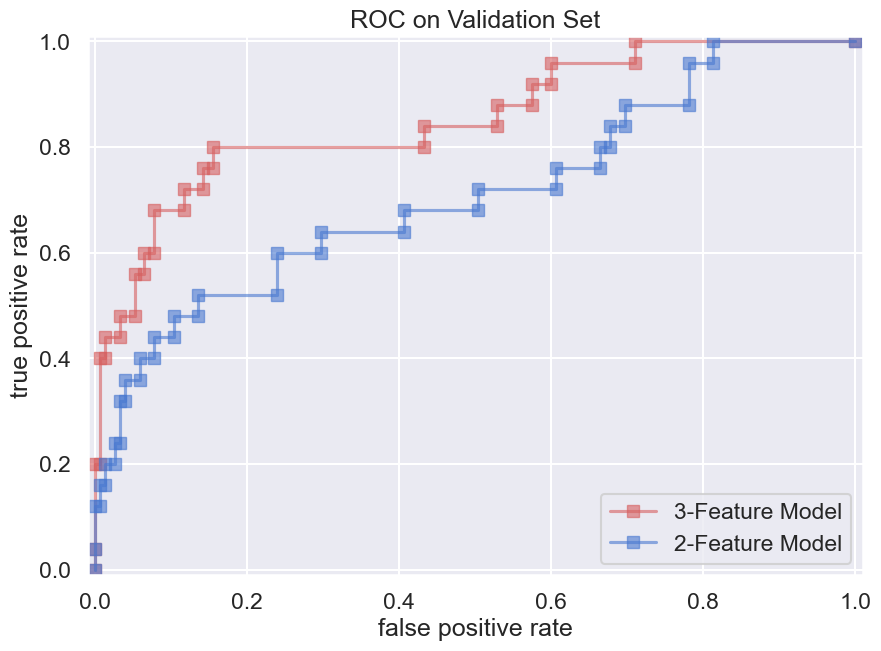

In [96]:
# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(10,7))

# TODO Use provided data and predictions on the Validation set
# Produce the ROC Curve utilizing `sklearn.metrics.roc_curve' within plt defined above.
# To start, read the official Document and examples of 'sklearn.metrics.roc_curve'. 

# Read HW2 instructions carefully for plot style (line type, line color, etc.)
va_roc_fpr_F2, va_roc_tpr_F2, va_roc_thrs_F2 = sklearn.metrics.roc_curve(y_va_N, bestlrF2_yproba1_va_N)
va_roc_fpr_F3, va_roc_tpr_F3, va_roc_thrs_F3 = sklearn.metrics.roc_curve(y_va_N, bestlrF3_yproba1_va_N)

plt.plot(va_roc_fpr_F3, va_roc_tpr_F3, 'rs-', alpha=0.6, label='3-Feature Model')
plt.plot(va_roc_fpr_F2, va_roc_tpr_F2, 'bs-', alpha=0.6, label='2-Feature Model')

plt.title("ROC on Validation Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);
sns.set(context='talk', style='darkgrid', palette='muted')

### Figure 1 for the report: Comparing models using ROC analysis
**TODO**:
Show the figure above in your report

#### Short Answer 1b

Compare the two models in terms of their ROC curves from Figure 1. Does one dominate the other in terms of overall performance across all thresholds, or are there some threshold regimes where the 2-feature model is preferred and other regimes where the 3-feature model is preferred? Which model do you recommend for the task at hand?

**Answer**  
In general the 3-Feature model dominates over the 2-Feature model. They seem similar at very high thresholds but the 3-Feature model rapidly takes the lead, staying above the 2-Feature model on the ROC plot until they converge again at (1.0,1.0).

## Selecting a decision threshold

Now that we've compared models, we need to decide on a classification *threshold* to obtain a binary decision from probabilities. 

To get candidate threshold values, use the helper function `compute_perf_metrics_across_thresholds` in the starter code file [threshold_selection.py](https://github.com/tufts-ml-courses/cs135-23f-assignments/blob/main/hw2/threshold_selection.py).

#### Implementation Step 1F

For the classifier from 1D above (LR for 3-features), calculate performance metrics using the default threshold of `y_proba < 0.5`. Produce the confusion matrix and calculate the TPR and PPV. 
*Tip: Remember that we have implemented helper functions for you in `confusion_matrix.py`.*

TODO:

* Use F=3 LR model, Use default 0.5 threshold
* Produce the confusion matrix
* Return TPR and PPV on the test set

In [235]:
calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, 0.5) # Confusion matrix on test set predictions

Predicted,0,1
True,,
0,152,3
1,15,10


In [238]:
best_thr_default = 0.5
tpr = calc_TPR(y_te_N, bestlrF3_yproba1_te_N>=best_thr_default) 
ppv = calc_PPV(y_te_N, bestlrF3_yproba1_te_N>=best_thr_default) 

print(f"Default threshold (0.5): chosen thr = {best_thr_default :.4f}, tpr = {tpr :.4f}, ppv = {ppv :.4f},")

Default threshold (0.5): chosen thr = 0.5000, tpr = 0.4000, ppv = 0.7692,


### Implementation Step 1G

For the classifier from 1D above (LR for 3-features), compute performance metrics across all candidate thresholds on the validation set (use `compute_perf_metrics_across_thresholds`). Then, pick the threshold that *maximizes TPR while satisfying PPV >= 0.98* on the validation set.
If there's a tie for the maximum TPR, chose the threshold corresponding to a higher PPV. 

Remember, you pick this threshold based on the *validation* set, then later you'll evaluate it on the *test* set.

**TODO**: Finish the code block to get the best threshold.

In [98]:
# Get the performance metrics across many thresholds
thresh_grid, va_perf_grid = threshold_selection.compute_perf_metrics_across_thresholds(
    y_va_N, bestlrF3_yproba1_va_N)

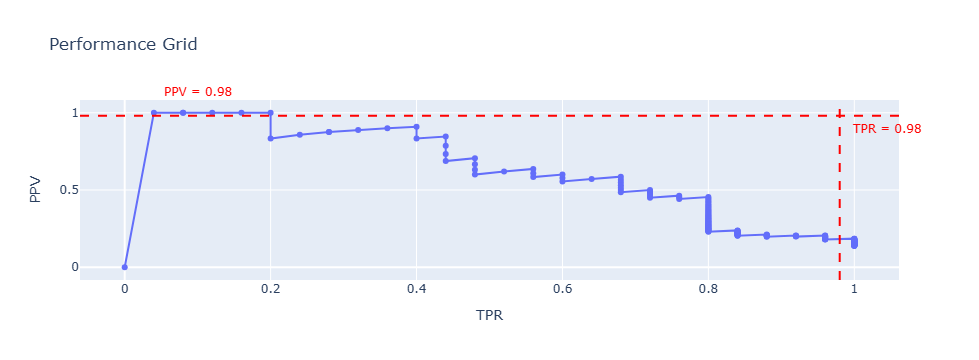

In [139]:
import plotly.express as px

fig = px.line(va_perf_grid, x='tpr', y='ppv', title='Performance Grid')
fig.update_layout(
    xaxis_title='TPR',
    yaxis_title='PPV'
)

fig.add_shape(
    type='line',
    x0=0.98, x1=0.98, y0=0, y1=1,
    xref='x', yref='paper',
    line=dict(color='Red', width=2, dash='dash')
)
fig.add_shape(
    type='line',
    x0=0, x1=1, y0=0.98, y1=0.98,
    xref='paper', yref='y',
    line=dict(color='Red', width=2, dash='dash')
)

fig.add_annotation(
    x=1.03,
    y=0.90,
    xref='paper',
    yref='y',
    text='TPR = 0.98',
    showarrow=False,
    font=dict(color='Red', size=12)
)

fig.add_annotation(
    x=0.1,
    y=1.1,
    xref='x',
    yref='paper',
    text='PPV = 0.98',
    showarrow=False,
    font=dict(color='Red', size=12)
)

fig.update_traces(mode='lines+markers')
fig.show()


In [240]:
# Find threshold that makes TPR as large as possible, while satisfying PPV >= 0.98
# TODO Find the the largest TPR while PPV >= 0.98


best_result_index = np.argmax(va_perf_grid['tpr'] * va_perf_grid['ppv'] * (va_perf_grid['ppv']>=0.98).astype(int))

best_thr_tpr = thresh_grid[best_result_index] # TODO fixme calc_ACC, calc_TPR, calc_PPV
tpr1 = va_perf_grid['tpr'][best_result_index] # TODO fixme
ppv1 = va_perf_grid['ppv'][best_result_index] # TODO fixme

print(f"Figure2 column 2: chosen thr = {best_thr_tpr :.4f}, tpr = {tpr1 :.4f}, ppv = {ppv1 :.4f},")

Figure2 column 2: chosen thr = 0.6311, tpr = 0.2000, ppv = 1.0000,


**TODO**: Using the chosen **best_thr** above
* Produce the confusion matrix on the test set
* Return TPR and PPV on the test set

In [244]:
calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, best_thr_tpr) # Confusion Matrix On test

Predicted,0,1
True,,
0,155,0
1,20,5


In [245]:
print(
    "ACC",
    calc_ACC(y_te_N, bestlrF3_yproba1_te_N>=best_thr_tpr),
    "TPR",
    calc_TPR(y_te_N, bestlrF3_yproba1_te_N>=best_thr_tpr),
    "PPV",
    calc_PPV(y_te_N, bestlrF3_yproba1_te_N>=best_thr_tpr)
)

ACC 0.8888888888883951 TPR 0.1999999999992 PPV 0.99999999998


### Implementation Step 1H

Now using the same F=3 LR model, pick a threshold to maximize PPV s.t. TPR >= 0.98

TODO: 
Using a similar logistic from **Step 1F** above
* Choose threshold that makes PPV as large as possible, while satisfying TPR >= 0.98
* Produce the confusion matrix using the chosen threshold
* Return TPR and PPV on the test set using the chosen threshold

In [242]:
# TODO Find the largest PPV while TPR >= 0.98

best_result_index = np.argmax(va_perf_grid['ppv'] * va_perf_grid['tpr'] * (va_perf_grid['tpr']>=0.98).astype(int))

best_thr_ppv = thresh_grid[best_result_index] # TODO fixme calc_ACC, calc_TPR, calc_PPV
tpr2 = va_perf_grid['tpr'][best_result_index] # TODO fixme
ppv2 = va_perf_grid['ppv'][best_result_index] # TODO fixme

print(f"Figure2 column 2: chosen thr = {best_thr_ppv :.4f}, tpr = {tpr2 :.4f}, ppv = {ppv2 :.4f},")

Figure2 column 2: chosen thr = 0.0296, tpr = 1.0000, ppv = 0.1852,


In [243]:
calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, best_thr_ppv) # Confusion Matrix On test

Predicted,0,1
True,,
0,57,98
1,0,25


In [246]:
print(
    "ACC",
    calc_ACC(y_te_N, bestlrF3_yproba1_te_N>=best_thr_ppv),
    "TPR",
    calc_TPR(y_te_N, bestlrF3_yproba1_te_N>=best_thr_ppv),
    "PPV",
    calc_PPV(y_te_N, bestlrF3_yproba1_te_N>=best_thr_ppv)
)

ACC 0.4555555555553025 TPR 0.9999999999960001 PPV 0.20325203252015994


#### Short Answer 1c

By carefully reading the confusion matrices above, for *each thresholding strategy* how many subjects in the test set are saved from unnecessary biopsies that would be done in current practice?

*Hint*: You can assume that currently, the hospital would have done a biopsy on every patient in the test set. Your goal is to build a classifier that improves on this practice. 

**Answer 1c**  
- The number of subjects saved from unnecessary biopsies in the test set is 155 for the TPR strategy, and 57 for the PPV strategy. Explanation: It is the number of true negatives. The people who did not have cancer and were predicted as not having cancer according to the threshold.

#### Short Answer 1d

Among the 3 possible thresholding strategies, which strategy best meets the stated goals of stakeholders in this screening task: avoid life-threatening mistakes whenever possible, while also eliminating unnecessary biopsies?
What fraction of current biopsies might be avoided if this strategy was adopted by the hospital? 

*Hint*: You can also assume the test set is a reasonable representation of the true population of patients.

**Answer 1d**

Avoiding **life-threatening mistakes** means maximizing **true positives** while avoiding **false negatives**. Minimizing **unnecessary biopsies** means minimizing **false positives** and maximizing **true negatives**. That is, achieving a balance between **TPR** and **PPV**. It turns out the default threshold (*50%*) is the best strategy with **TPR** = *0.4000*, **PPV** = *0.7692*. This strategy detects cancer in more than double of what the **TPR** strategy does, and avoids almost 3 times as many unnecessary biopsies as the **PPV** strategy.


# Reflection

1. How many hours, approximatley, did this homework take you?
2. What did you feel was most confusing about this homework?
3. Did you recieve help on this homework from any classmates, stack overflow threads, AI tools, Youtube videos, etc. for this homework? If so, please list them here. 

**Asnwer**
The coding part took me about 15 minutes. The report about 5 hours.  
I believe the lesson from the part about evaluating threshold strategies was that often optimizing for the maximum value of either TPR or PPV does not produce a good predictive model. Is this correct?  
I used Windows Copilot to produce the proper functions and syntax for plotting. (e.g. "What is the command for setting the x axis label on matplotlib plt figure?")